<a href="https://colab.research.google.com/github/vfrantc/trans_experiments/blob/main/play_with_star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv
from scipy.sparse import spdiags

In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [4]:
!cp /content/drive/MyDrive/001.png .

In [10]:
a = np.array([1.0, 2.0, 3.0])

In [17]:
def norm(a):
  return np.sqrt(np.sum(a**2))

3.7416573867739413

In [ ]:
def solveLinearSystem(s, ir, uvx, uvy, alphabet, b=0, lmbd=0, method='pcg'):
    h, w = s.shape[:2]
    hw = h * w

    # calculate the five-point positive definite Laplacian matrix
    uvx = uvx.ravel()
    uvy = uvy.ravel()
    # check how this padarray does work in matlab
    ux = np.padarray(uvx, h, 'pre')
    ux = ux[:-h]
    uy = np.padarray(uvy, 1, 'pre')
    uy = uy[:-1]
    D = uvx + ux + uvy + uy
    # what is spdiags in the matlab
    T = np.spdiags([-uvx, -uvy],[-h,-1],hw,hw)
    # calculate the variable of linear system
    MN = T + T.T + spdiags(D, 0, hw, hw);               # M in Eq.(12) or N in Eq.(13)    
    ir2 = ir**2                                         # R^{T}R in Eq.(12) or I^{T}I in Eq.(13)
    ir2 = np.spdiags(ir2(:),0,hw,hw)
    DEN = ir2 + alphabet * MN + lmbd * np.speye(hw, hw) # denominator in Eq.(12) or Eq.(13)
    NUM = ir.*s + lmbd * b                              # numerator in Eq.(12) or Eq.(13) 
    L = ichol(DEN,struct('michol','on'))
    [dst,~] = pcg(DEN, NUM(:), 0.01, 40, L, L.T) 
    dst = np.reshape(dst, (h, w))
    return dst

In [19]:
src = cv2.imread('001.png', 1)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
src = src.astype(np.float64) / 256
src = rgb2hsv(src)
src = src[:, :, 2]

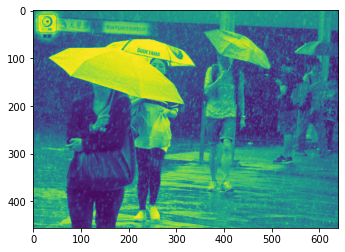

In [20]:
plt.imshow(src)
plt.show()

In [8]:
alpha=0.001
beta=0.0001
pI=1.5
pR=0.5
varreps = 0.01
r = 3
K=20
debug=True

In [18]:
src.shape

(456, 640, 3)

In [20]:
% it seems to be unnecessary, it gets reinitialized immediately
I=S;             % initialize I_0 % initialize the iterations, initialize Illumination with the value = S
R=ones(size(S)); % initialize R_0 % R -> reflection, start with all the ones
% 
if debug == true
    fprintf('-- Stop iteration until eplison < %02f or K > %d\n', vareps, K);
end
for iter = 1:K % for maximum of 20 values
    preI=I; % take the previous value of the illumination
    preR=R; % reflection map -> the best one
    
    %% algorithm for P1
    %pI=max(pI,pR);, estimation for the P1 - it's not clear what it is
    I=S./R;                             % I=S./R take the current I as the source image devided by estimated reflection. In python simple devision
    Ix = diff(I,1,2);                   % Estimate diff on the x-axis
    Ix = padarray(Ix, [0 1], 'post');   % Post ->
    Iy = diff(I,1,1);                   % 
    Iy = padarray(Iy, [1 0], 'post');   % 
    avgIx=convBox( single(Ix), r);      % so convbox should be a specific thing?? r - is 
    avgIy=convBox( single(Iy), r);
    ux = max(abs(avgIx).^pI,eps).^(-1);  % structure map avgIx.^pI > avgIx.*Ix > Ix.^2
    uy = max(abs(avgIy).^pI,eps).^(-1);  % structure map
    ux(:,end) = 0;
    uy(end,:) = 0;
    
    I = solveLinearSystem(S, R, ux, uy, alpha);  % Eq.(12)
    eplisonI = norm(I-preI, 'fro')/norm(preI, 'fro');   % iterative error of I
    
    %% algorithm for P2
    %pR=min(pI,pR);
    R=S./I;
    Rx = diff(R,1,2); Rx = padarray(Rx, [0 1], 'post');
    Ry = diff(R,1,1); Ry = padarray(Ry, [1 0], 'post');
    avgRx=convBox( single(Rx), r);
    avgRy=convBox( single(Ry), r);
    vx = max(abs(avgRx).^pR,eps).^(-1);  % texture map
    vy = max(abs(avgRy).^pR,eps).^(-1);  % texture map
    vx(:,end) = 0;
    vy(end,:) = 0;
    
    R = solveLinearSystem(S, I, vx, vy, beta);            	% Eq.(13)
    eplisonR = norm(R-preR, 'fro')/norm(preR, 'fro');   % iterative error of R
    
6
    if(eplisonI<vareps||eplisonR<vareps)
        break;
    end
end
I(I<0)=0;
R(R<0)=0;
end